In [2]:
!pip install transformers

In [5]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import requests
from PIL import Image

from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation


Result saved to pose_result.jpg
Result saved to pose_result.jpg


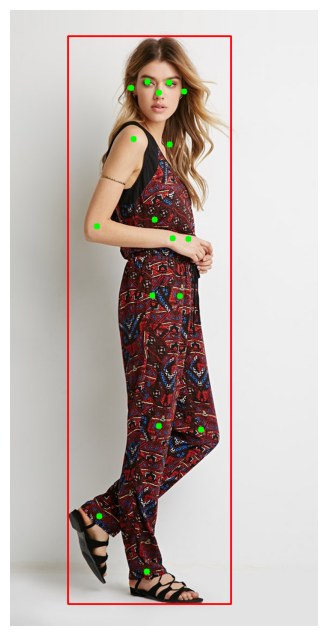

In [29]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load image
image_path = "/content/WOMEN-Rompers_Jumpsuits-id_00004432-02_2_side.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ------------------------------------------------------------------------
# Stage 1: Detect humans on the image
# ------------------------------------------------------------------------
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365").to(device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

# Convert image dimensions correctly
target_sizes = torch.tensor([(image.shape[0], image.shape[1])])  # (height, width)

# Process detections
results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.3
)
result = results[0]  # Take first image results

# Extract person boxes (label 0 is "person" in COCO dataset)
person_boxes = result["boxes"][result["labels"] == 0].cpu().numpy()

# Convert from (x1, y1, x2, y2) to (x1, y1, width, height)
person_boxes[:, 2] -= person_boxes[:, 0]
person_boxes[:, 3] -= person_boxes[:, 1]

# Draw bounding boxes
for box in person_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# ------------------------------------------------------------------------
# Stage 2: Detect keypoints for each person found
# ------------------------------------------------------------------------
pose_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
pose_model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple").to(device)

inputs = pose_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = pose_model(**inputs)

pose_results = pose_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])

# Extract first detected person's keypoints
if isinstance(pose_results, list) and len(pose_results) > 0 and isinstance(pose_results[0], list) and len(pose_results[0]) > 0:  # Line 1
    image_pose_result = pose_results[0][0]  # Unpack the nested list  # Line 2

    # Extract keypoints (x, y) and confidence scores
    keypoints = image_pose_result["keypoints"].cpu().numpy()  # Convert to NumPy  # Line 3
    scores = image_pose_result["scores"].cpu().numpy()  # Confidence scores  # Line 4

    # Draw keypoints on image
    for (x, y), score in zip(keypoints, scores):  # Line 5
        if score > 0.3:  # Filter by confidence  # Line 6
            cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)  # Line 7

    # Save and show results
    output_path = "pose_result.jpg"  # Line 8
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Line 9
    print(f"Result saved to {output_path}")  # Line 10
else:
    print("No pose results detected.")  # Line 11

# ------------------------------------------------------------------------
# Save and display results
# ------------------------------------------------------------------------
output_path = "pose_result.jpg"
cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
print(f"Result saved to {output_path}")

# Show image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()


Line map saved to keypoint_line_map_WOMEN-Leggings-id_00002117-03_1_front.png
Overlay image saved to keypoint_overlay_WOMEN-Leggings-id_00002117-03_1_front.png


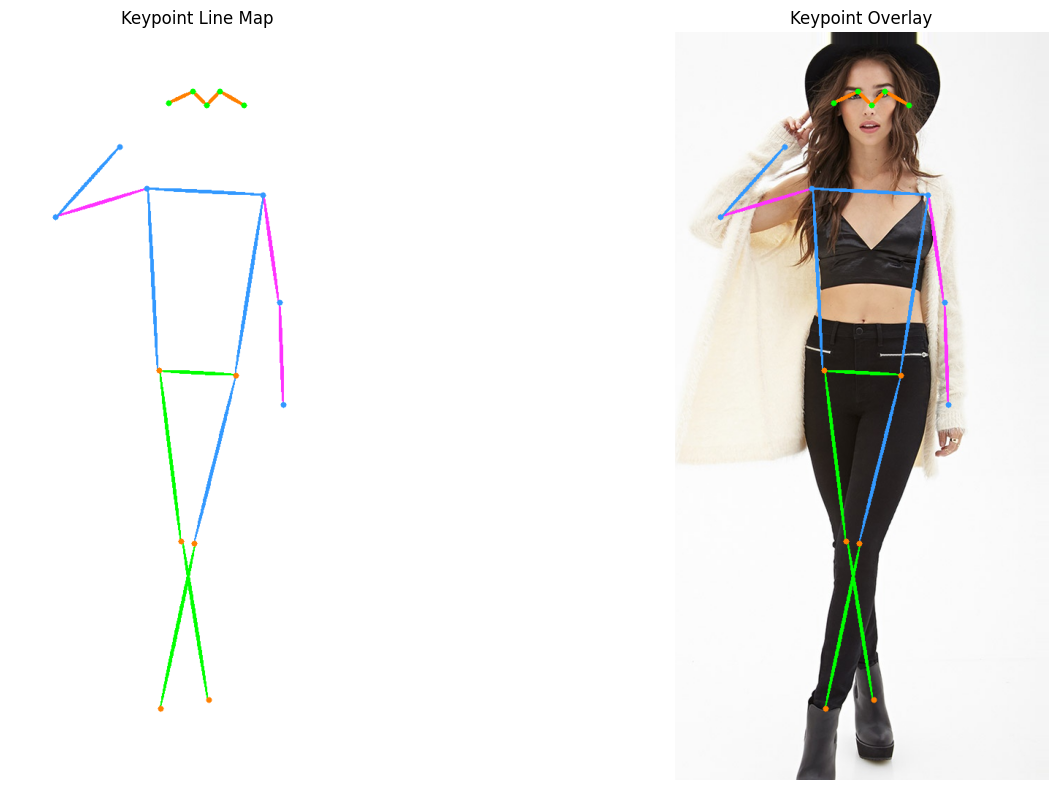

In [37]:
def draw_points(image, keypoints, scores, keypoint_colors, keypoint_score_threshold=0.3, radius=4):
    for kid, (kpt, kpt_score) in enumerate(zip(keypoints, scores)):
        x_coord, y_coord = int(kpt[0]), int(kpt[1])
        if kpt_score > keypoint_score_threshold:
            color = tuple(int(c) for c in keypoint_colors[kid])
            cv2.circle(image, (int(x_coord), int(y_coord)), radius, color, -1)

def draw_links(image, keypoints, scores, keypoint_edges, link_colors, keypoint_score_threshold=0.3, stick_width=2):
    height, width, _ = image.shape

    for sk_id, sk in enumerate(keypoint_edges):
        x1, y1, score1 = (int(keypoints[sk[0], 0]), int(keypoints[sk[0], 1]), scores[sk[0]])
        x2, y2, score2 = (int(keypoints[sk[1], 0]), int(keypoints[sk[1], 1]), scores[sk[1]])

        if (x1 > 0 and x1 < width and y1 > 0 and y1 < height and
            x2 > 0 and x2 < width and y2 > 0 and y2 < height and
            score1 > keypoint_score_threshold and score2 > keypoint_score_threshold):

            color = tuple(int(c) for c in link_colors[sk_id])

            # Calculate line parameters
            length = ((y1 - y2) ** 2 + (x1 - x2) ** 2) ** 0.5
            angle = math.degrees(math.atan2(y1 - y2, x1 - x2))

            # Create a more sophisticated line representation
            polygon = cv2.ellipse2Poly(
                (int((x1 + x2) / 2), int((y1 + y2) / 2)),
                (int(length / 2), stick_width),
                int(angle),
                0, 360, 1
            )

            cv2.fillConvexPoly(image, polygon, color)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load image

# example 0
# image_path = "/content/WOMEN-Blouses_Shirts-id_00001719-01_4_full.png"
# example 1
# image_path = "/content/WOMEN-Blouses_Shirts-id_00002789-04_4_full.png"

# example 2
# image_path = "/content/WOMEN-Jackets_Coats-id_00007580-01_7_additional.png"
# example 3
image_path = "/content/WOMEN-Leggings-id_00002117-03_1_front.png"

# example 4
# image_path = "/content/WOMEN-Rompers_Jumpsuits-id_00004432-02_2_side.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ------------------------------------------------------------------------
# Stage 1: Detect humans on the image
# ------------------------------------------------------------------------
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365").to(device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

# Convert image dimensions correctly
target_sizes = torch.tensor([(image.shape[0], image.shape[1])])  # (height, width)

# Process detections
results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.3
)
result = results[0]  # Take first image results

# Extract person boxes (label 0 is "person" in COCO dataset)
person_boxes = result["boxes"][result["labels"] == 0].cpu().numpy()

# Convert from (x1, y1, x2, y2) to (x1, y1, width, height)
person_boxes[:, 2] -= person_boxes[:, 0]
person_boxes[:, 3] -= person_boxes[:, 1]

# ------------------------------------------------------------------------
# Stage 2: Detect keypoints for each person found
# ------------------------------------------------------------------------
pose_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
pose_model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple").to(device)

inputs = pose_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = pose_model(**inputs)

# Process keypoints
pose_results = pose_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])

# Create a palette of colors
palette = np.array([
    [255, 128, 0],
    [255, 153, 51],
    [255, 178, 102],
    [230, 230, 0],
    [255, 153, 255],
    [153, 204, 255],
    [255, 102, 255],
    [255, 51, 255],
    [102, 178, 255],
    [51, 153, 255],
    [255, 153, 153],
    [255, 102, 102],
    [255, 51, 51],
    [153, 255, 153],
    [102, 255, 102],
    [51, 255, 51],
    [0, 255, 0],
    [0, 0, 255],
    [255, 0, 0],
    [255, 255, 255],
])

# COCO keypoint connection order
keypoint_edges = [
    (0, 1),   # nose to left eye
    (0, 2),   # nose to right eye
    (1, 3),   # left eye to left ear
    (2, 4),   # right eye to right ear
    (5, 7),   # left shoulder to left elbow
    (7, 9),   # left elbow to left wrist
    (6, 8),   # right shoulder to right elbow
    (8, 10),  # right elbow to right wrist
    (5, 11),   # left shoulder to left hip
    (6, 12),   # right shoulder to right hip
    (5, 6),   # left shoulder to right shoulder
    (11, 13), # left hip to left knee
    (13, 15), # left knee to left ankle
    (12, 14), # right hip to right knee
    (14, 16), # right knee to right ankle
    (11, 12)  # left hip to right hip
]

# Choose link colors
link_colors = palette[[0, 0, 0, 0, 7, 7, 7, 9, 9, 9, 9, 9, 16, 16, 16, 16, 16, 16, 16]]

# Create keypoint colors
keypoint_colors = palette[[16, 16, 16, 16, 16, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0]]

# Extract first detected person's keypoints
if isinstance(pose_results, list) and len(pose_results) > 0 and isinstance(pose_results[0], list) and len(pose_results[0]) > 0:
    image_pose_result = pose_results[0]

    # Create images for different visualizations
    line_map = np.ones_like(image) * 255
    overlay_image = image.copy()

    # Process each detected pose
    for pose_result in image_pose_result:
        keypoints = np.array(pose_result["keypoints"])
        scores = np.array(pose_result["scores"])

        # Draw links on both images
        draw_links(line_map, keypoints, scores, keypoint_edges, link_colors)
        draw_links(overlay_image, keypoints, scores, keypoint_edges, link_colors)

        # Draw points on both images
        draw_points(line_map, keypoints, scores, keypoint_colors)
        draw_points(overlay_image, keypoints, scores, keypoint_colors)

    # Generate output filenames
    base_filename = os.path.basename(image_path)
    name, ext = os.path.splitext(base_filename)

    # Save line map
    line_map_path = f"keypoint_line_map_{name}{ext}"
    cv2.imwrite(line_map_path, cv2.cvtColor(line_map, cv2.COLOR_RGB2BGR))
    print(f"Line map saved to {line_map_path}")

    # Save overlay image
    overlay_path = f"keypoint_overlay_{name}{ext}"
    cv2.imwrite(overlay_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))
    print(f"Overlay image saved to {overlay_path}")

    # Optional: Display both images
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(line_map)
    plt.title('Keypoint Line Map')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_image)
    plt.title('Keypoint Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No pose results detected.")